## An 1D example for demonstration

In [1]:
import torch
import gpytorch
from gpytorch.kernels import *
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import viva
from viva import VIVACpp as VIVA, my_train_cpp as my_train
from data_gen import Normal_y_gen

A function that generates training data randomly but testing data on a grid such that the prediction curve will appear continuous. 

In [2]:
def gen_data_mixed(nTrain, d, lengthscale=None, nugget4f=0.0, nugget4y=0.1,
                   nu=0.5,
                   seed=0, nTest=0, outputscale=1.0, y_gen=None):
    """
    Generate training data randomly and generate testing data on a grid
    """
    n = nTrain + nTest
    # Build locations (X)
    torch.manual_seed(seed)
    X_train = torch.rand(nTrain, d)
    nKnot = int(nTest ** (1 / d)) + 1
    edge = torch.linspace(0, 1, steps=nKnot)
    X_test = torch.flatten(
        torch.stack(torch.meshgrid([edge] * d, indexing='ij')),
        start_dim=1).t()[:nTest]
    X = torch.cat([X_train, X_test], dim=0)
    # Define a covariance kernel
    if lengthscale is None:
        lengthscale = torch.linspace(0.5, 2.5, d)
    logNugget4f = torch.log(torch.tensor(nugget4f))
    logNugget4y = torch.log(torch.tensor(nugget4y))
    K = ScaleKernel(MaternKernel(ard_num_dims=d, nu=nu))
    K.base_kernel.lengthscale = lengthscale
    K.outputscale = outputscale
    kernel4f = viva.Kernel(X, K, torch.exp(logNugget4f).item())
    # Build responses (y)
    covM4f = kernel4f(list(range(n)))
    GPObj4f = MultivariateNormal(torch.zeros(n), covM4f)
    f = GPObj4f.sample()
    if y_gen is None:
        y_gen = lambda x: x + \
                          torch.normal(torch.zeros(len(x)),
                                       nugget4y)
    y = y_gen(f)
    # y = y.sub(y.mean())
    return X, f, y, K, logNugget4f, logNugget4y

A function for plotting the true `f`, the observed responses `y`, and the predicted confidence intervals.

In [3]:
def my_plot(x, f, y, fhat, fhat_sd, fn):
    fig_size = (6, 5)
    marker_size = 2
    font_size = 24
    line_width = 2.0
    alpha = 0.3
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax_objs = [ax.scatter(x, y, s=marker_size ** 2, alpha=alpha,
                          c='#d62728'),
               ax.plot(x, f, c='#1f77b4', linewidth=line_width)[0],
               ax.errorbar(x, fhat, 2.0 * fhat_sd, alpha=alpha, c='#ff7f0e')]
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_ylabel(None, fontsize=font_size)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
    fig.set_tight_layout(True)
    fig_legend = plt.figure(figsize=(4 * 3, 1))
    legend_names = ["y", "f", "f | y"]
    fig_legend.legend(ax_objs, legend_names, 'lower center',
                      fontsize=font_size, ncol=len(legend_names))

Defining likelihood function and the generator for `y | f`.

In [4]:
y_gen = Normal_y_gen(0.3)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.3 ** 2
classify = False  # Set to true if likelihood is logit (binary classification)

Generate data and kernel.

In [5]:
n_train = 200
n_test = 200
d = 1
rho = 2.0
X, f, y, K, logNugget4f, logNugget4y = \
    gen_data_mixed(n_train, d, nugget4f=0.0001, lengthscale=0.1,
                   y_gen=y_gen, nugget4y=0.1, nu=1.5, nTest=n_test)
X_train = X[:n_train]
X_test = X[n_train:]
f_test = f[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
mu_init = torch.zeros(y.shape)

Creat and train the VIVA model. A plot will be produced at the end.

/Users/caoj/Documents/VIVA_tmp/venv/lib/python3.11/site-packages/viva/utils.py:198: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  [n, n]).to_sparse_csr()


Maxmin ordering for n = 400, d = 1, rho = 2.0 used 0.110365220985841 seconds
Laplacian initialization used 0.16101355498540215 seconds
time_update_U = 0.010816501977387816, time_ELBO_fwd = 0.04764776898082346, time_ELBO_bwd = 0.04762588095036335, time_sp_trisolve = 0.0012689270079135895, time_sub_matrix = 0.005003593018045649 time_innerMean = 0.00016667999443598092 time_logDet = 0.0003974249993916601 time_expected_likelihood = 0.03109959198627621
Epoch 0 ELBO is -672.1935424804688
time_update_U = 0.02501360495807603, time_ELBO_fwd = 0.0942313919949811, time_ELBO_bwd = 0.06323660796624608, time_sp_trisolve = 0.0026723060000222176, time_sub_matrix = 0.012227264029206708 time_innerMean = 0.0003285739803686738 time_logDet = 0.0008262869960162789 time_expected_likelihood = 0.055738390976330265
Epoch 1 ELBO is -4159.50341796875
time_update_U = 0.03712457398069091, time_ELBO_fwd = 0.13851055002305657, time_ELBO_bwd = 0.07833515998208895, time_sp_trisolve = 0.003770084003917873, time_sub_matri

Epoch 23 ELBO is -333.8138732910156
time_update_U = 0.299302756000543, time_ELBO_fwd = 1.0743552760395687, time_ELBO_bwd = 0.4290378949663136, time_sp_trisolve = 0.027674945769831538, time_sub_matrix = 0.13674490578705445 time_innerMean = 0.004095344978850335 time_logDet = 0.010491792025277391 time_expected_likelihood = 0.6344518538971897
Epoch 24 ELBO is -331.94805908203125
time_update_U = 0.31038027597242035, time_ELBO_fwd = 1.1165070360293612, time_ELBO_bwd = 0.4469333949673455, time_sp_trisolve = 0.028762344794813544, time_sub_matrix = 0.14197582879569381 time_innerMean = 0.004296244966099039 time_logDet = 0.01090209002722986 time_expected_likelihood = 0.6593775239016395
Epoch 25 ELBO is -330.0448913574219
time_update_U = 0.32170676297391765, time_ELBO_fwd = 1.1581004400213715, time_ELBO_bwd = 0.4619262799678836, time_sp_trisolve = 0.029819998831953853, time_sub_matrix = 0.14762063379748724 time_innerMean = 0.004436177958268672 time_logDet = 0.011288743029581383 time_expected_likel

/var/folders/n2/vrqrl8bx2xvgrrn31z6lfxzr0000gn/T/ipykernel_19712/1839968853.py:19: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  fig_legend.legend(ax_objs, legend_names, 'lower center',


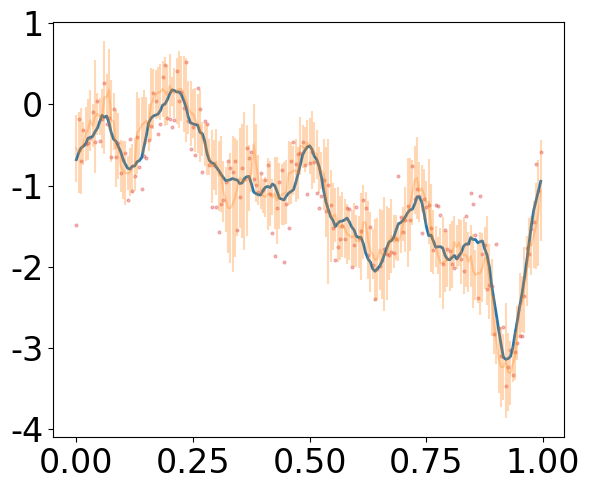

<Figure size 1200x100 with 0 Axes>

In [6]:
model = VIVA(X, y, K, likelihood, rho, n_test=n_test,
                 classify=classify, use_ic0=True)
my_train(model, n_Epoch=30)
mu_post, var_post = model.predict()
sd_post = var_post.sqrt()
mu_post_VIVA = mu_post.detach().clone()
sd_post_VIVA = sd_post.detach().clone()
my_plot(X_test[:, 0], f_test.detach(), y_test.detach(),
        mu_post.detach(), sd_post.detach(),
        None)